In [1]:
import os
from glob import glob
import warnings

import dask
import numpy as np
import pandas as pd
import xarray as xr

from utils import city_list, gev_metric_ids
import metric_funcs as mf

In [19]:
ds = xr.open_dataset('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/extreme_value/original_grid/min_tasmin/LOCA2_ACCESS-CM2_r1i1p1f1_historical_1950-2014_stat_lmom_main.nc')

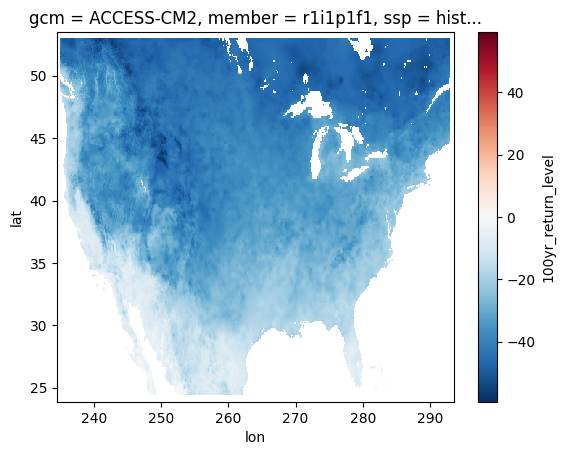

In [20]:
ds['100yr_return_level'].plot()

In [2]:
# #################
# # Dask (hopper)
# #################
# from dask.distributed import LocalCluster
# cluster = LocalCluster(n_workers = 20, threads_per_worker=1, processes=True)
# client = cluster.get_client()
# client

In [3]:
# ############
# ### Dask ###
# ############
# from dask_jobqueue import SLURMCluster

# cluster = SLURMCluster(
#     account="pches_cr_default",
#     queue='basic',
#     cores=1,
#     processes=1,
#     memory="30GiB",
#     walltime="01:00:00",
# )

# cluster.scale(jobs=10)  # ask for jobs

# from dask.distributed import Client
# client = Client(cluster)
# client

### GMET

In [4]:
## Paths 
# Update these for reproduction
from utils import hopper_code_path as project_code_path
from utils import hopper_data_path as project_data_path

gmet_path = "/home/fs01/dcl257/data/gmet"

store_path = f"{project_data_path}/metrics/obs/gmet/"

In [5]:
%%time
# Loop through ensemble members
for ens_member in range(1, 101):
    # Read
    ens_member_str = str(ens_member).zfill(3)
    if len(glob(f"{store_path}/*_{ens_member_str}.nc")) < 3:
        files = glob(f"{gmet_path}/conus_daily_eighth_*_{ens_member_str}.nc4")
        ds = xr.concat([xr.open_dataset(file) for file in files], dim='time').sortby('time')
    
    # max tasmax
    out_path = f"{store_path}/max_tasmax_gmet_{ens_member_str}.nc"
    if not os.path.exists(out_path):
        ds_tasmax = mf.calculate_max(ds, 'tasmax')
        ds_tasmax.to_netcdf(out_path)
        del ds_tasmax

    # min tasmin
    out_path = f"{store_path}/min_tasmin_gmet_{ens_member_str}.nc"
    if not os.path.exists(out_path):
        ds_tasmin = mf.calculate_min(ds, 'tasmin')
        ds_tasmin.to_netcdf(out_path)
        del ds_tasmin

    # max pr
    out_path = f"{store_path}/max_pr_gmet_{ens_member_str}.nc"
    if not os.path.exists(out_path):
        ds_pr = mf.calculate_max(ds, 'pr')
        ds_pr.to_netcdf(out_path)
        del ds_pr

    # Clean up
    if 'ds' in locals():
        del ds

CPU times: user 3h 16min 3s, sys: 1h 2min 57s, total: 4h 19min
Wall time: 5h 36min 58s


## Livneh-unsplit

In [11]:
## Paths 
# Update these for reproduction
from utils import roar_code_path as project_code_path
from utils import roar_data_path as project_data_path

livneh_path = "/storage/group/pches/default/users/dcl5300/livneh_unsplit"

store_path = f"{project_data_path}/metrics/obs/livneh_unsplit/"

In [ ]:
# Read all: temperature
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ds = xr.open_mfdataset(f"{livneh_path}/temperature_wind/*.nc")

# max tasmax
ds_tasmax = ds[['Tmax']].resample(time='YE').max().compute()
ds_tasmax.rename({'Tmax':'tasmax'}).to_netcdf(f"{store_path}/max_tasmax_livneh_unsplit.nc")

# min tasmin
ds_tasmax = ds[['Tmin']].resample(time='YE').min().compute()
ds_tasmax.rename({'Tmin':'tasmin'}).to_netcdf(f"{store_path}/min_tasmin_livneh_unsplit.nc")

# max cdd
ds_cdd = mf.calculate_dd_max(ds.rename({'Tmin':'tasmin', 'Tmax':'tasmax'}),
                            var_id = 'cdd')
ds_cdd.to_netcdf(f"{store_path}/max_cdd_livneh_unsplit.nc")

# max hdd
ds_hdd = mf.calculate_dd_max(ds.rename({'Tmin':'tasmin', 'Tmax':'tasmax'}),
                             var_id = 'hdd')
ds_hdd.to_netcdf(f"{store_path}/max_hdd_livneh_unsplit.nc")

In [18]:
# Read all: precip
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ds = xr.open_mfdataset(f"{livneh_path}/precipitation/*.nc")

# max pr
ds_pr = ds[['PRCP']].resample(Time='YE').max().compute()
ds_pr.rename({'PRCP':'pr', 'Time':'time'}).to_netcdf(f"{store_path}/max_pr_livneh_unsplit.nc")

## NClimGrid

In [3]:
## Paths 
# Update these for reproduction
from utils import roar_code_path as project_code_path
from utils import roar_data_path as project_data_path

nclimgrid_path = "/storage/group/pches/default/users/dcl5300/nClimGrid-Daily/ncei_daily_grids"
nclimgrid_years = os.listdir(nclimgrid_path)
nclimgrid_files = glob(f'{nclimgrid_path}/**/*.nc', recursive=True)

store_path = f"{project_data_path}/metrics/obs/NClimGrid/"

In [4]:
def calculate_metric(year, metric_func, var_id,
                     nclimgrid_path = nclimgrid_path):
    # Read year
    files = glob(f'{nclimgrid_path}/{year}/*.nc')
    ds = xr.concat([xr.load_dataset(file) for file in files], dim='time')

    # Calculate metric
    ds = metric_func(ds, var_id)

    return ds

In [10]:
# max tasmax
metric_func = mf.calculate_max
var_id = 'tasmax'

# Loop through years
ds_out = []
for year in nclimgrid_years:
    ds_tmp = dask.delayed(calculate_metric)(year=year, 
                                            metric_func=metric_func,
                                            var_id=var_id)
    ds_out.append(ds_tmp)

ds_out = xr.concat(dask.compute(*ds_out), dim='time')

# Store
ds_out.to_netcdf(f"{store_path}/max_{var_id_out}_nclimgrid.nc")

In [15]:
# min tasmin
metric_func = mf.calculate_min
var_id = 'tasmin'

# Loop through years
ds_out = []
for year in nclimgrid_years:
    ds_tmp = dask.delayed(calculate_metric)(year=year, 
                                            metric_func=metric_func,
                                            var_id=var_id)
    ds_out.append(ds_tmp)

ds_out = xr.concat(dask.compute(*ds_out), dim='time')

# Store
ds_out.to_netcdf(f"{store_path}/min_{var_id_out}_nclimgrid.nc")

In [16]:
# max pr
metric_func = mf.calculate_max
var_id = 'pr'

# Loop through years
ds_out = []
for year in nclimgrid_years:
    ds_tmp = dask.delayed(calculate_metric)(year=year, 
                                            metric_func=metric_func,
                                            var_id=var_id)
    ds_out.append(ds_tmp)

ds_out = xr.concat(dask.compute(*ds_out), dim='time')

# Store
ds_out.to_netcdf(f"{store_path}/max_{var_id_out}_nclimgrid.nc")

In [5]:
# max cdd
metric_func = mf.calculate_dd_max
var_id = 'cdd'

# Loop through years
ds_out = []
for year in nclimgrid_years:
    ds_tmp = dask.delayed(calculate_metric)(year=year, 
                                            metric_func=metric_func,
                                            var_id=var_id)
    ds_out.append(ds_tmp)

ds_out = xr.concat(dask.compute(*ds_out), dim='time')

# Store
ds_out.to_netcdf(f"{store_path}/max_{var_id}_nclimgrid.nc")

In [6]:
# max cdd
metric_func = mf.calculate_dd_max
var_id = 'hdd'

# Loop through years
ds_out = []
for year in nclimgrid_years:
    ds_tmp = dask.delayed(calculate_metric)(year=year, 
                                            metric_func=metric_func,
                                            var_id=var_id)
    ds_out.append(ds_tmp)

ds_out = xr.concat(dask.compute(*ds_out), dim='time')

# Store
ds_out.to_netcdf(f"{store_path}/max_{var_id}_nclimgrid.nc")